<a href="https://colab.research.google.com/github/Arindam2002/tensorflow_learning/blob/main/06_transfer_learning_in_tensorflow_part_3_(scaling_up).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TF Part 3: Scaling up (Food Vision mini)

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating helper functions

In [ ]:
!wget https://raw.githubusercontent.com/Arindam2002/tensorflow_learning/main/helper_functions.py

--2022-07-15 09:23:46--  https://raw.githubusercontent.com/Arindam2002/tensorflow_learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10857 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.60K  --.-KB/s    in 0s      

2022-07-15 09:23:47 (109 MB/s) - ‘helper_functions.py’ saved [10857/10857]



In [ ]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-07-15 09:23:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   152MB/s    in 9.7s    

2022-07-15 09:24:03 (159 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/guacamole'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 ima

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)      # don't shuffle test data for prediction analysis 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a model with transfer learning on 10% of 101 food classes

Steps:
* Create a ModelCheckpoint callback 
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import  preprocessing
from tensorflow.keras import Sequential

data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomZoom(0.2),
#   preprocessing.Rescaling(1/255)  # required for models like ResNet50
], name="data_augmentation")

In [ ]:
# Setup the base model and freeze it's layers (this will extract features)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import  preprocessing
from tensorflow.keras import Sequential

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training = False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(units=len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics="accuracy")

In [ ]:
# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
          epochs=5,
          validation_data=test_data,
          validation_steps=int(0.15 * len(test_data)),
          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 51s 191ms/step - loss: 3.4806 - accuracy: 0.2441 - val_loss: 2.6922 - val_accuracy: 0.4023
Epoch 2/5
237/237 [==============================] - 43s 182ms/step - loss: 2.3465 - accuracy: 0.4646 - val_loss: 2.2810 - val_accuracy: 0.4661
Epoch 3/5
237/237 [==============================] - 42s 174ms/step - loss: 1.9717 - accuracy: 0.5303 - val_loss: 2.0826 - val_accuracy: 0.4913
Epoch 4/5
237/237 [==============================] - 42s 174ms/step - loss: 1.7504 - accuracy: 0.5787 - val_loss: 2.0097 - val_accuracy: 0.4963
Epoch 5/5
237/237 [==============================] - 40s 169ms/step - loss: 1.5919 - accuracy: 0.6107 - val_loss: 1.9681 - val_accuracy: 0.4987


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 61s 77ms/step - loss: 1.7260 - accuracy: 0.5500


[1.725973129272461, 0.5499802231788635]

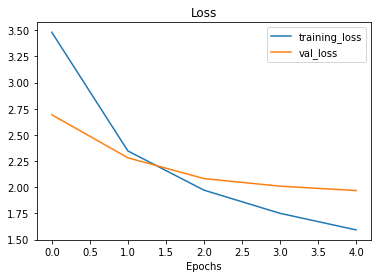

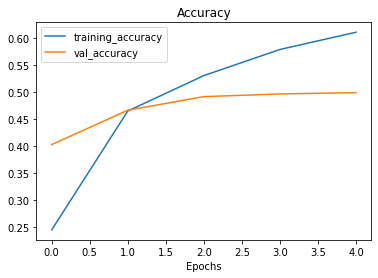

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Re-freeze all the layers in the model except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Re-compile the model with lower learning rate (it's usually best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),   # learning rate lowered by 10x
              metrics=["accuracy"])

In [ ]:
# Check out which layers in the model are trainable (Just to confirm once)
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check out which layers in the base_model are trainable
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_2 False
rescaling_1 False
normalization_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [ ]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10   # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 48s 173ms/step - loss: 1.3613 - accuracy: 0.6490 - val_loss: 1.9386 - val_accuracy: 0.5016
Epoch 6/10
237/237 [==============================] - 36s 150ms/step - loss: 1.2256 - accuracy: 0.6788 - val_loss: 1.9308 - val_accuracy: 0.5048
Epoch 7/10
237/237 [==============================] - 37s 153ms/step - loss: 1.1463 - accuracy: 0.6940 - val_loss: 1.9471 - val_accuracy: 0.5040
Epoch 8/10
237/237 [==============================] - 36s 149ms/step - loss: 1.0723 - accuracy: 0.7189 - val_loss: 1.9175 - val_accuracy: 0.5122
Epoch 9/10
237/237 [==============================] - 36s 150ms/step - loss: 1.0239 - accuracy: 0.7263 - val_loss: 1.9701 - val_accuracy: 0.5037
Epoch 10/10
237/237 [==============================] - 33s 140ms/step - loss: 0.9579 - accuracy: 0.7456 - val_loss: 1.9266 - val_accuracy: 0.5127


In [ ]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 58s 74ms/step - loss: 1.6275 - accuracy: 0.5742


[1.6274986267089844, 0.5742177963256836]

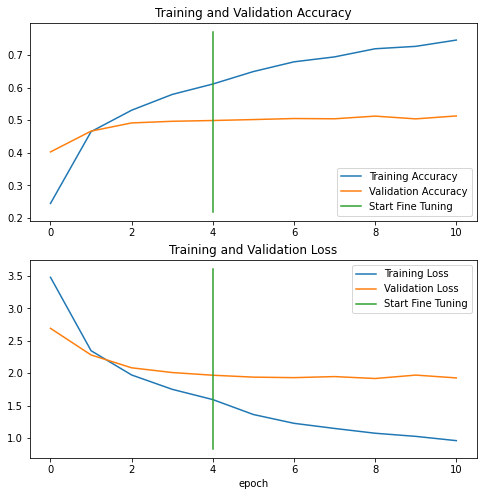

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/Models/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/101_food_classes_10_percent_saved_big_dog_model/assets


In [ ]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/Models/101_food_classes_10_percent_saved_big_dog_model")

> Check if the model loaded is correct

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 64s 79ms/step - loss: 1.6275 - accuracy: 0.5742


[1.6274986267089844, 0.5742177963256836]

In [ ]:
# Results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.6274986267089844, 0.5742177963256836]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [ ]:
# Download pretrained model (the above one)
model = tf.keras.models.load_model("drive/MyDrive/Models/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 70s 73ms/step - loss: 1.6275 - accuracy: 0.5742


[1.6274986267089844, 0.5742177963256836]

## Making predictions with our trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 63s 78ms/step


In [ ]:
len(test_data)

790

In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[2.0272247e-01, 3.3463791e-04, 1.3997832e-01, ..., 5.8600923e-05,
        3.7946500e-04, 1.0573648e-01],
       [8.8396686e-01, 4.3950743e-07, 2.1242313e-03, ..., 3.4535867e-03,
        6.7793405e-07, 2.4203084e-06],
       [2.3013155e-01, 1.7389897e-02, 1.2878095e-02, ..., 6.9758145e-04,
        6.9545058e-04, 4.8585869e-03],
       ...,
       [1.3716364e-01, 8.3910300e-06, 1.6128358e-03, ..., 4.8934907e-02,
        3.4096045e-04, 8.0990299e-05],
       [1.6935387e-01, 1.4455522e-03, 8.1117071e-02, ..., 2.4878504e-04,
        3.8360638e-05, 4.4249572e-04],
       [2.9679716e-01, 6.8566605e-06, 6.2492199e-04, ..., 1.6327824e-02,
        3.5775470e-06, 1.6972753e-03]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([2.02722475e-01, 3.34637909e-04, 1.39978319e-01, 4.70124277e-08,
        3.04663513e-06, 4.24680229e-06, 2.65803828e-05, 2.99490948e-05,
        1.64674725e-02, 6.65449828e-04, 1.50843243e-06, 8.82096083e-06,
        2.13650381e-03, 2.08847882e-06, 2.43460890e-02, 4.60604788e-04,
        3.04750847e-05, 1.60276389e-03, 8.74186808e-04, 1.21130452e-05,
        3.92719114e-04, 3.16765036e-05, 2.30794351e-04, 2.13036852e-04,
        3.93554074e-04, 8.37198575e-04, 1.47634302e-04, 3.23758977e-05,
        2.39377409e-01, 4.00596019e-03, 3.55521161e-06, 1.93839218e-03,
        2.02619378e-03, 4.98616544e-07, 8.60673748e-03, 3.95794341e-05,
        1.25166742e-04, 9.52385017e-04, 4.14260365e-02, 3.80296406e-05,
        3.37740144e-04, 1.01346639e-03, 2.99892412e-03, 5.39257780e-06,
        4.92982872e-05, 6.81419551e-05, 8.73516838e-04, 1.60924479e-04,
        1.72708258e-06, 2.81176493e-02, 3.88960500e-04, 2.23615934e-05,
        4.94567752e-02, 5.67128463e-03, 4.55931113e-05, 7.271851

> Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}\n")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}\n")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}\n")

Number of prediction probabilities for sample 0: 101

What prediction probability sample 0 looks like:
 [2.02722475e-01 3.34637909e-04 1.39978319e-01 4.70124277e-08
 3.04663513e-06 4.24680229e-06 2.65803828e-05 2.99490948e-05
 1.64674725e-02 6.65449828e-04 1.50843243e-06 8.82096083e-06
 2.13650381e-03 2.08847882e-06 2.43460890e-02 4.60604788e-04
 3.04750847e-05 1.60276389e-03 8.74186808e-04 1.21130452e-05
 3.92719114e-04 3.16765036e-05 2.30794351e-04 2.13036852e-04
 3.93554074e-04 8.37198575e-04 1.47634302e-04 3.23758977e-05
 2.39377409e-01 4.00596019e-03 3.55521161e-06 1.93839218e-03
 2.02619378e-03 4.98616544e-07 8.60673748e-03 3.95794341e-05
 1.25166742e-04 9.52385017e-04 4.14260365e-02 3.80296406e-05
 3.37740144e-04 1.01346639e-03 2.99892412e-03 5.39257780e-06
 4.92982872e-05 6.81419551e-05 8.73516838e-04 1.60924479e-04
 1.72708258e-06 2.81176493e-02 3.88960500e-04 2.23615934e-05
 4.94567752e-02 5.67128463e-03 4.55931113e-05 7.27185141e-03
 2.87346430e-02 3.85336316e-04 2.77129351e

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([28,  0,  0,  8, 29, 78, 29, 46,  9, 72])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

> Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
len(test_data)

790

## Evaluating our model's predictions

One way to check that our model's predictions array (`pred_classes`) is in the same order as our test labels array (`y_labels`) is to find the accuracy score.

In [ ]:
results_downloaded_model

[1.6274986267089844, 0.5742177963256836]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix 

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

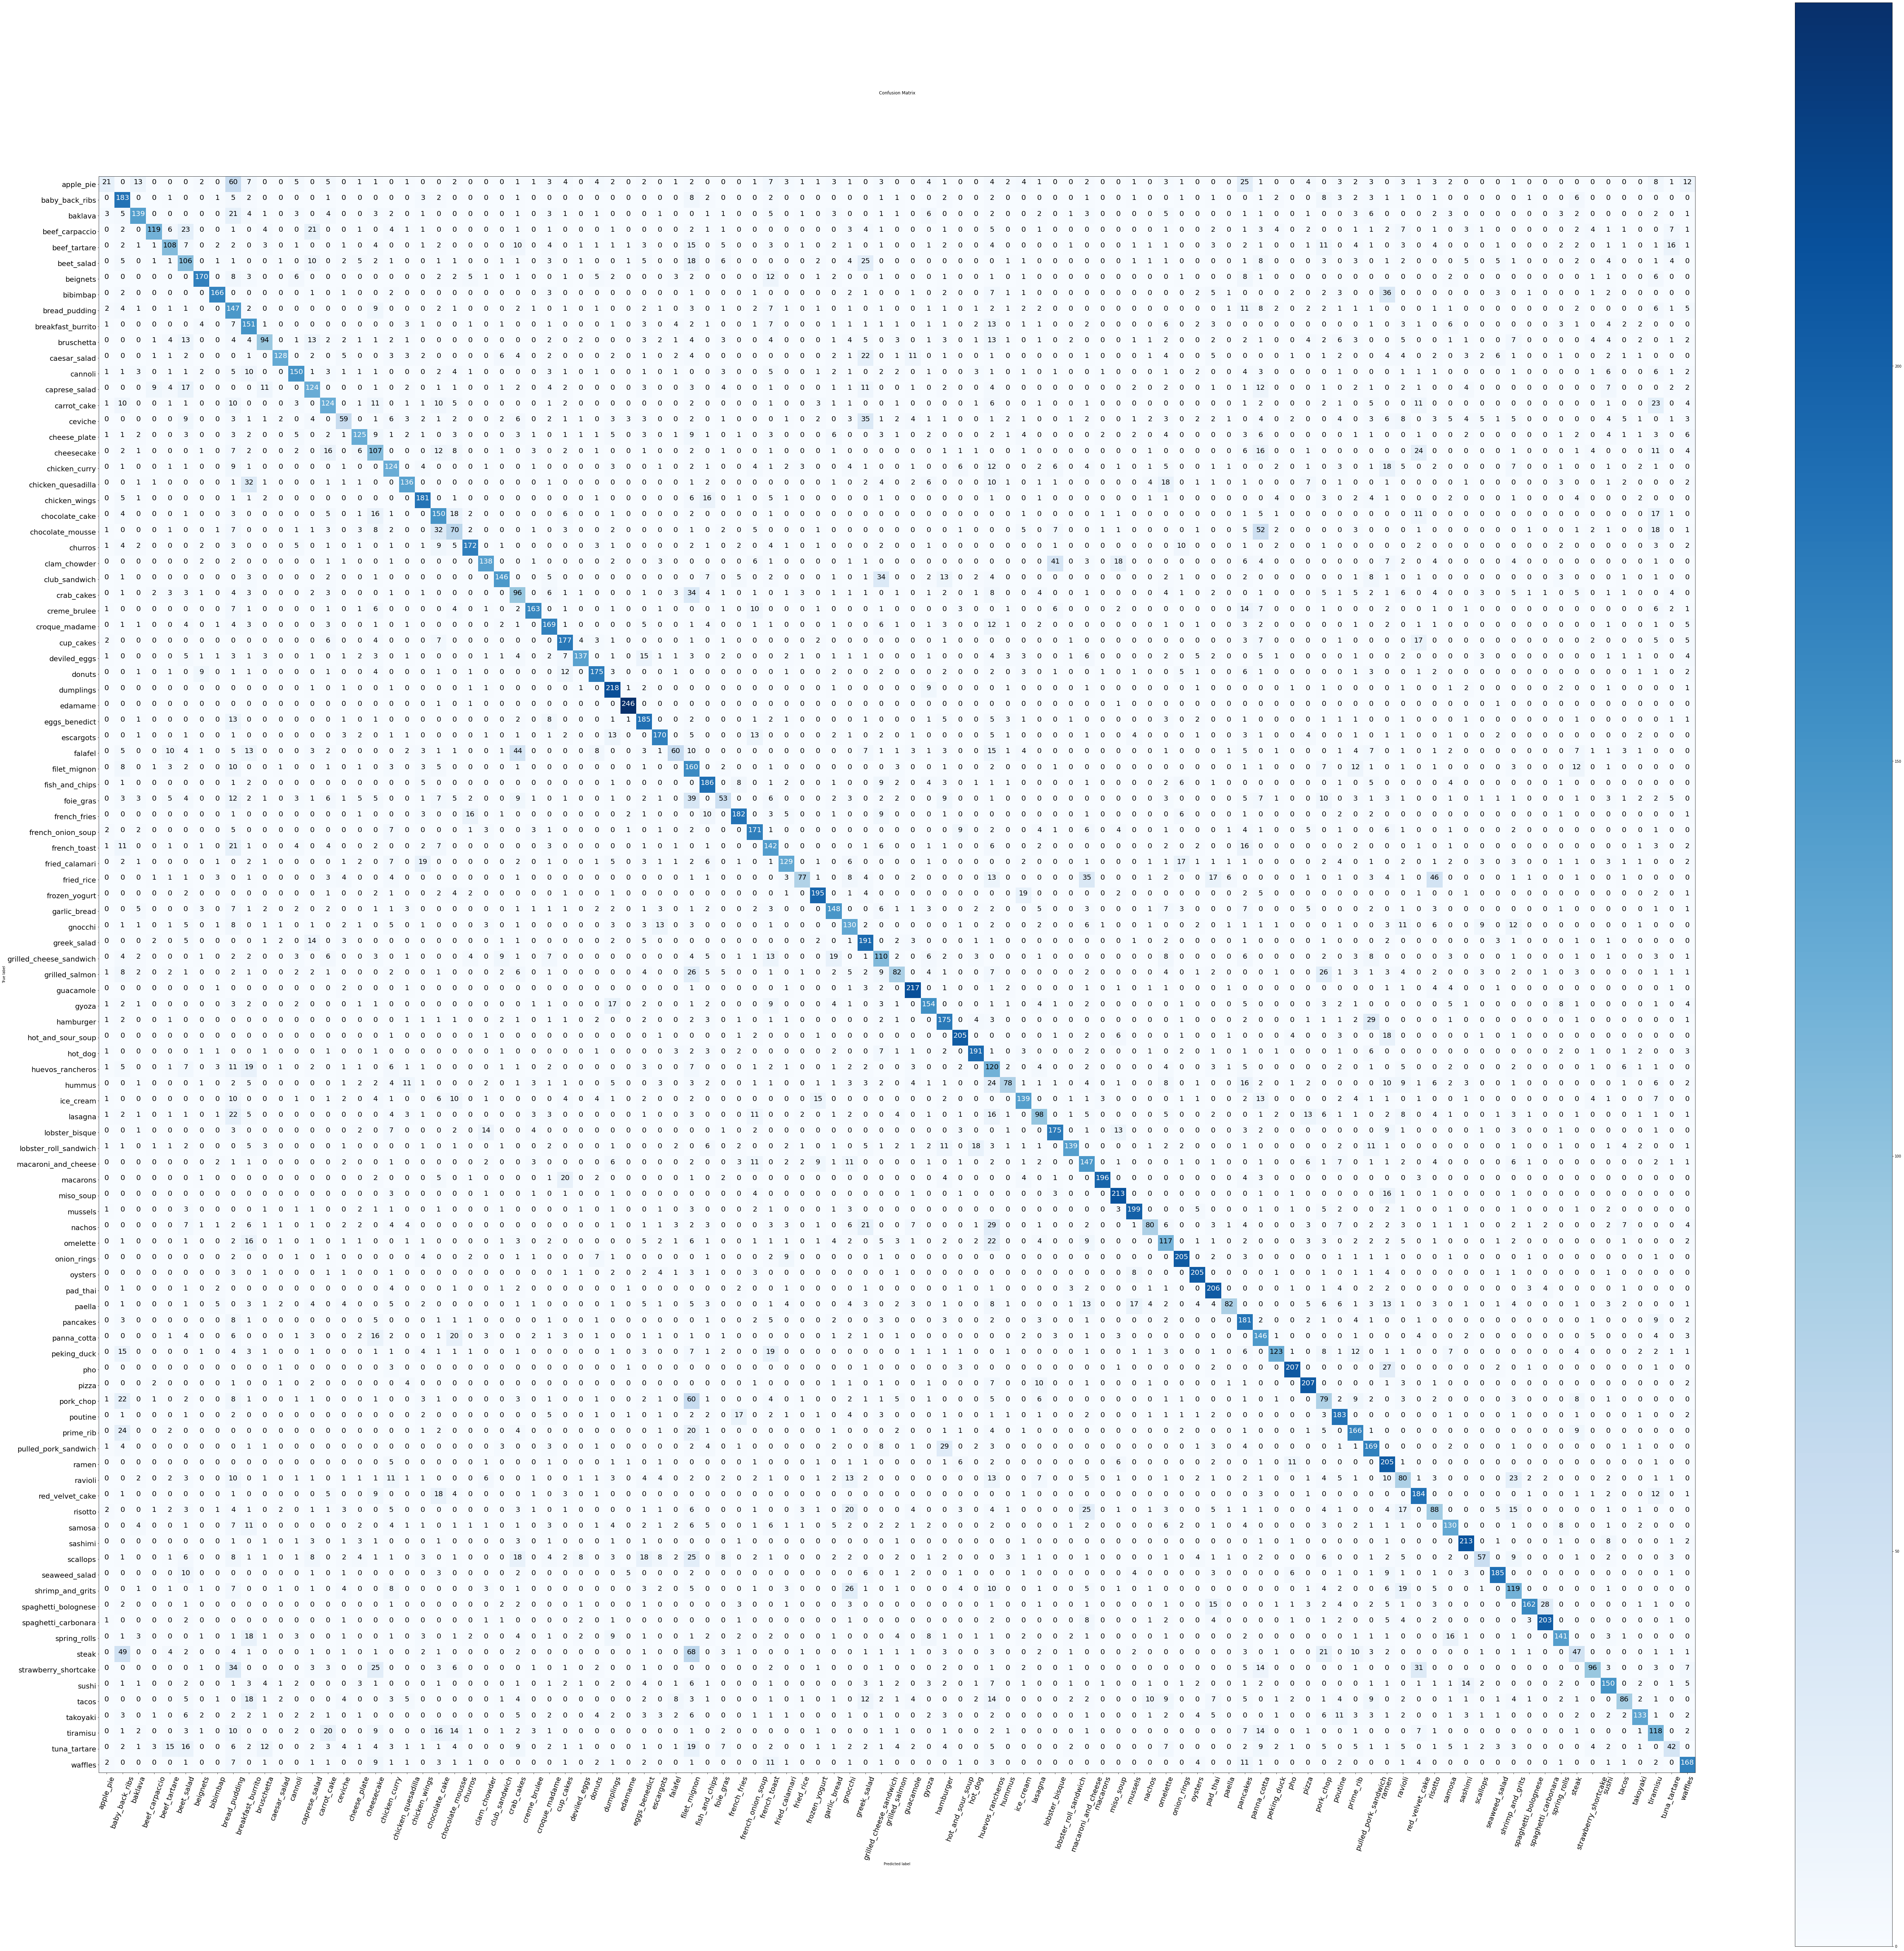

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep evaluating, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.38      0.08      0.14       250
           1       0.43      0.73      0.54       250
           2       0.69      0.56      0.62       250
           3       0.80      0.48      0.60       250
           4       0.57      0.43      0.49       250
           5       0.34      0.42      0.38       250
           6       0.81      0.68      0.74       250
           7       0.85      0.66      0.74       250
           8       0.24      0.59      0.34       250
           9       0.39      0.60      0.48       250
          10       0.59      0.38      0.46       250
          11       0.86      0.51      0.64       250
          12       0.70      0.60      0.65       250
          13       0.51      0.50      0.50       250
          14       0.50      0.50      0.50       250
          15       0.45      0.24      0.31       250
          16       0.66      0.50      0.57       250
          17       0.35    

> The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

> Let's create a visualization to get a better understanding.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.13770491803278687,
  'precision': 0.38181818181818183,
  'recall': 0.084,
  'support': 250},
 '1': {'f1-score': 0.5446428571428571,
  'precision': 0.43364928909952605,
  'recall': 0.732,
  'support': 250},
 '10': {'f1-score': 0.4585365853658537,
  'precision': 0.5875,
  'recall': 0.376,
  'support': 250},
 '100': {'f1-score': 0.6176470588235294,
  'precision': 0.5714285714285714,
  'recall': 0.672,
  'support': 250},
 '11': {'f1-score': 0.6432160804020101,
  'precision': 0.8648648648648649,
  'recall': 0.512,
  'support': 250},
 '12': {'f1-score': 0.6451612903225806,
  'precision': 0.6976744186046512,
  'recall': 0.6,
  'support': 250},
 '13': {'f1-score': 0.5040650406504064,
  'precision': 0.512396694214876,
  'recall': 0.496,
  'support': 250},
 '14': {'f1-score': 0.4979919678714859,
  'precision': 0.5,
  'recall': 0.496,
  'support': 250},
 '15': {'f1-score': 0.30890052356020936,
  'precision': 0.44696969696969696,
  'recall': 0.236,
  'support': 250},
 '16': {'

> Let's plot all of our classes F1-scores...

In [ ]:
class_names[100]

'waffles'

In [ ]:
# Create an empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for key, value in classification_report_dict.items():
  if key=="accuracy":   # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(key)]] = value["f1-score"]

class_f1_scores

{'apple_pie': 0.13770491803278687,
 'baby_back_ribs': 0.5446428571428571,
 'baklava': 0.6150442477876107,
 'beef_carpaccio': 0.5979899497487438,
 'beef_tartare': 0.4920273348519362,
 'beet_salad': 0.3765541740674956,
 'beignets': 0.737527114967462,
 'bibimbap': 0.7443946188340808,
 'bread_pudding': 0.3418604651162791,
 'breakfast_burrito': 0.47559055118110233,
 'bruschetta': 0.4585365853658537,
 'caesar_salad': 0.6432160804020101,
 'cannoli': 0.6451612903225806,
 'caprese_salad': 0.5040650406504064,
 'carrot_cake': 0.4979919678714859,
 'ceviche': 0.30890052356020936,
 'cheese_plate': 0.5681818181818182,
 'cheesecake': 0.38768115942028986,
 'chicken_curry': 0.4732824427480916,
 'chicken_quesadilla': 0.6085011185682327,
 'chicken_wings': 0.6961538461538462,
 'chocolate_cake': 0.5226480836236934,
 'chocolate_mousse': 0.3070175438596491,
 'churros': 0.7303609341825901,
 'clam_chowder': 0.6330275229357798,
 'club_sandwich': 0.6606334841628959,
 'crab_cakes': 0.3615819209039548,
 'creme_brul

In [ ]:
sorted(class_f1_scores.items(), key=lambda item: item[1])

[('apple_pie', 0.13770491803278687),
 ('tuna_tartare', 0.23863636363636365),
 ('steak', 0.2422680412371134),
 ('foie_gras', 0.28571428571428575),
 ('pork_chop', 0.30268199233716475),
 ('chocolate_mousse', 0.3070175438596491),
 ('ceviche', 0.30890052356020936),
 ('ravioli', 0.31189083820662766),
 ('huevos_rancheros', 0.31662269129287596),
 ('scallops', 0.32947976878612717),
 ('falafel', 0.33707865168539325),
 ('bread_pudding', 0.3418604651162791),
 ('filet_mignon', 0.3466955579631636),
 ('crab_cakes', 0.3615819209039548),
 ('risotto', 0.37130801687763704),
 ('beet_salad', 0.3765541740674956),
 ('cheesecake', 0.38768115942028986),
 ('grilled_salmon', 0.40694789081885857),
 ('tiramisu', 0.4206773618538324),
 ('grilled_cheese_sandwich', 0.4230769230769231),
 ('hummus', 0.42622950819672134),
 ('nachos', 0.42895442359249325),
 ('omelette', 0.4349442379182157),
 ('fried_rice', 0.44),
 ('tacos', 0.44559585492227977),
 ('lasagna', 0.45581395348837206),
 ('panna_cotta', 0.45696400625978084),
 ('

In [ ]:
# Turn f1-scores into dataframes for visualization
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores

class_names  f1-score
33              edamame  0.955340
63             macarons  0.857768
75                  pho  0.836364
91  spaghetti_carbonara  0.826884
86              sashimi  0.814532
..                  ...       ...
77            pork_chop  0.302682
39            foie_gras  0.285714
93                steak  0.242268
99         tuna_tartare  0.238636
0             apple_pie  0.137705

[101 rows x 2 columns]

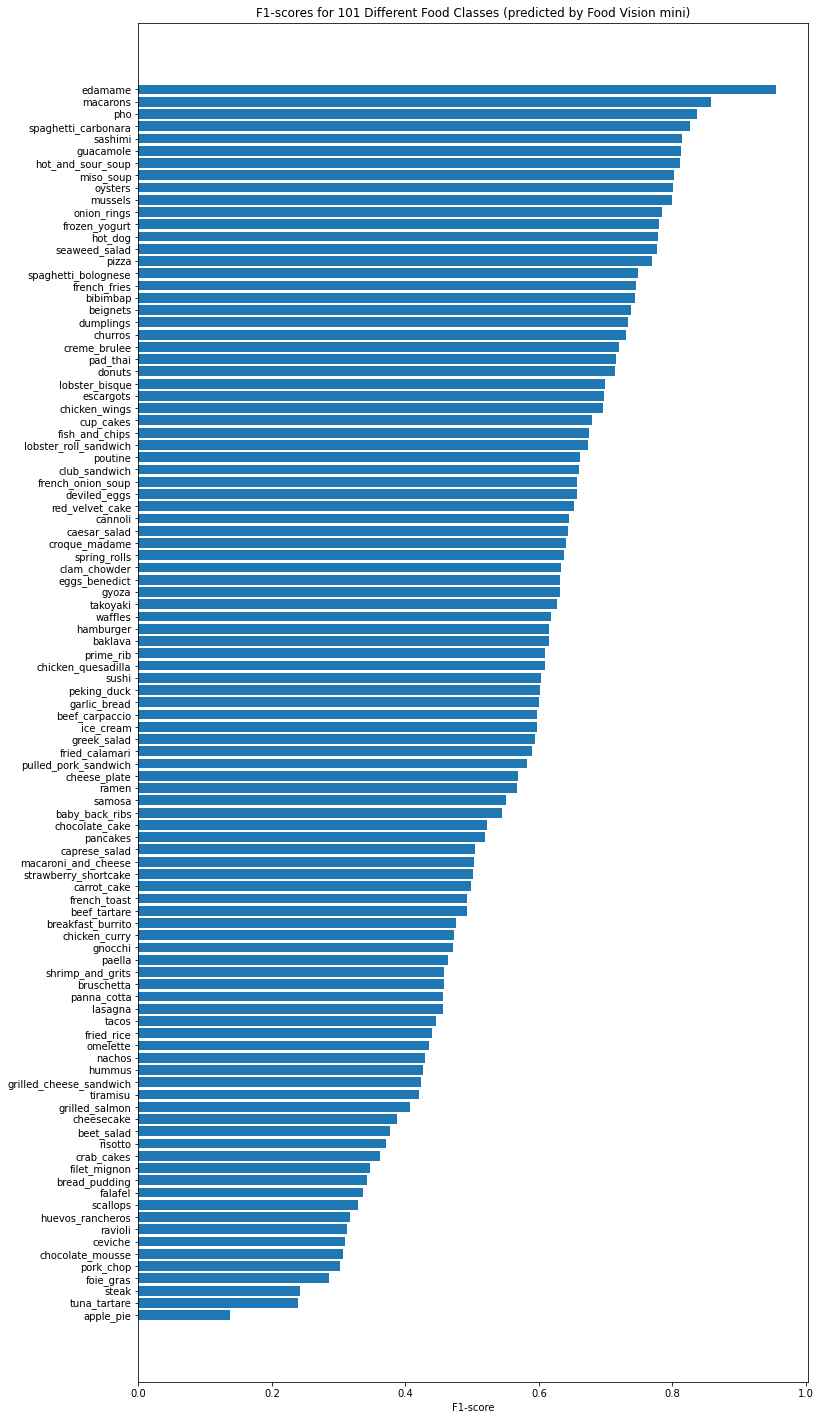

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

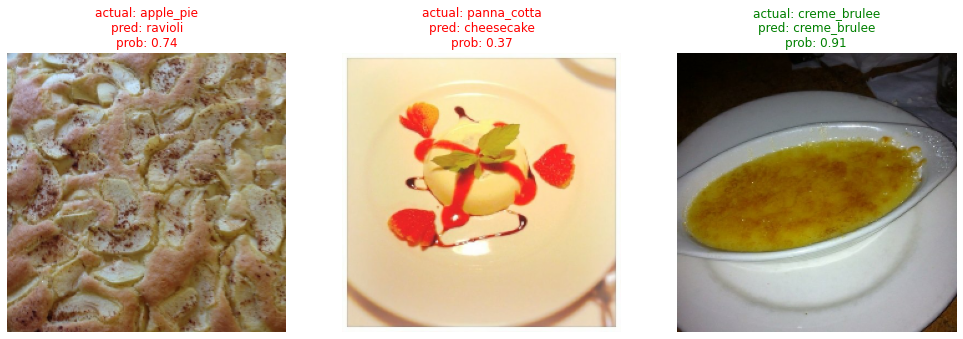

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random image(s) from random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  # print(img)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}\npred: {pred_class}\nprob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

 ## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      28   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0       8   
4      b'/content/101_food_classes_10_percent/test/ap...       0      29   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname y_pred_classname  
0       0.239377        apple_pie    croque_madame  
1       0.883967        apple_pie        apple_pie  
2       0.230132        apple_pie        apple_pie  
3       0.169737        apple_pie    bread_pudding  
4       0.332461        apple_pie        cup_cakes  
...          ...              ...              ...  
25245   0.987186          waffles          waffles  
25246   0.726312          waffles          waffles  
25247   0.566313          waffles          waffles  
25248   0.426950          waffles          waffles  
25249   0.520434          waffles          waffles  

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      28   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0       8   
4  b'/content/101_food_classes_10_percent/test/ap...       0      29   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.239377        apple_pie    croque_madame         False  
1   0.883967        apple_pie        apple_pie          True  
2   0.230132        apple_pie        apple_pie          True  
3   0.169737        apple_pie    bread_pudding         False  
4   0.332461        apple_pie        cup_cakes         False

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
22203  b'/content/101_food_classes_10_percent/test/se...      88      51   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
22511  b'/content/101_food_classes_10_percent/test/sp...      90      78   
11041  b'/content/101_food_classes_10_percent/test/fr...      44      51   
21216  b'/content/101_food_classes_10_percent/test/ri...      84      70   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
5849   b'/content/101_food_classes_10_percent/test/ch...      23      68   
19521  b'/content/101_food_classes_10_percent/test/po...      78      40   
5114   b'/content/101_food_classes_10_percent/test/ch...      20      38   
22044  b'/content/101_food_classes_10_percent/test/se...      88       5   
11097  b'/content/101_food_classes_10_percent/test/fr...      44      70   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
18935  b'/content/101_food_classes_10_percent/test/ph...      75      33   
21913  b'/content/101_food_classes_10_percent/test/sc...      87       5   
11974  b'/content/101_food_classes_10_percent/test/gn...      47      35   

       pred_conf       y_true_classname y_pred_classname  pred_correct  
23797   0.999687                  sushi          sashimi         False  
23631   0.999572   strawberry_shortcake  red_velvet_cake         False  
22203   0.997545          seaweed_salad        guacamole         False  
17855   0.997006                 paella          mussels         False  
10847   0.996272         fried_calamari      onion_rings         False  
22511   0.995464    spaghetti_bolognese          poutine         False  
11041   0.995225             fried_rice        guacamole         False  
21216   0.995107                risotto         pad_thai         False  
10854   0.994892         fried_calamari      onion_rings         False  
18001   0.994791               pancakes         omelette         False  
11642   0.994050           garlic_bread       bruschetta         False  
5849    0.993349                churros      onion_rings         False  
19521   0.993332                poutine     french_fries         False  
5114    0.993291          chicken_wings   fish_and_chips         False  
22044   0.993120          seaweed_salad       beet_salad         False  
11097   0.992429             fried_rice         pad_thai         False  
15359   0.992354  lobster_roll_sandwich        hamburger         False  
18935   0.992087                    pho          edamame         False  
21913   0.991191               scallops       beet_salad         False  
11974   0.990146                gnocchi        escargots         False

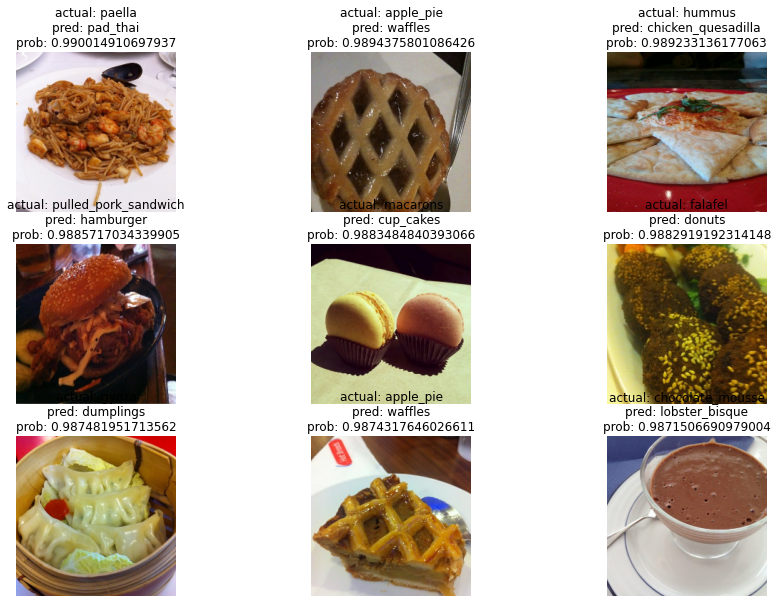

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}\npred: {y_pred_classname}\nprob: {pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-07-15 11:29:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.119.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-07-15 11:29:48 (112 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


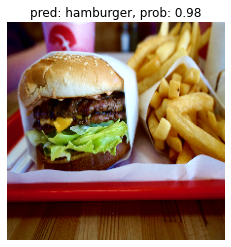

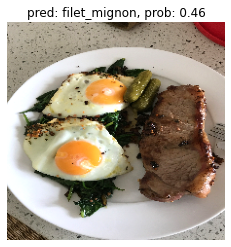

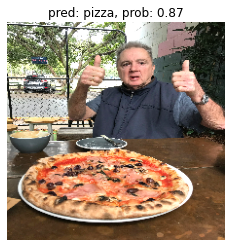

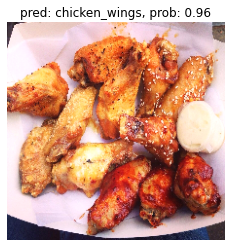

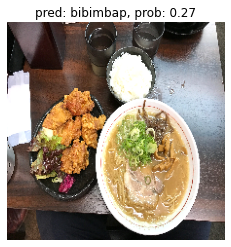

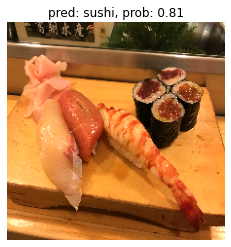

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)